In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

path = os.getcwd()
for _ in range(2):
    path = os.path.dirname(path)

if not path in sys.path:
    sys.path.append(path)

In [3]:
import torch
import pytorch_lightning as pl
import os
import ModelFusion.helpers.pytorch_utils as ptu

from ModelFusion.helpers.load_data import load_data
from ModelFusion.helpers.load_model import load_model, reload_model
from ModelFusion.helpers.pl_helpers import TrainClf, get_logger
from pytorch_lightning.callbacks import ModelCheckpoint
from ModelFusion.helpers.utils import vis_images

In [4]:
ds_name = "CIFAR10"
model_name = "ViT"
save_dir = "../"
log_name = "clf_logs"
if_debug = False
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

## 1. Read data

In [5]:
train_ds = load_data(ds_name, "train")
val_ds = load_data(ds_name, "val")
# train_ds[0][0].shape, train_ds[0][1], val_ds[0][0].shape, val_ds[0][1]

Files already downloaded and verified
Files already downloaded and verified


## 2. Load model

In [6]:
X_test = train_ds[0][0].unsqueeze(0)
model = load_model(model_name)
pred, hidden_states = model(X_test)
# L = 5 : 4 patches + 1 cls_token
pred.shape, hidden_states[0].shape,  len(hidden_states)

(torch.Size([1, 10]), torch.Size([1, 65, 768]), 12)

In [7]:
model = load_model(model_name)

## 3. Training

In [8]:
ds_dict = {
    "train": train_ds,
    "val": val_ds
}
model = load_model(model_name)
lit_model = TrainClf(ds_dict, model)

In [9]:
logger, time_stamp = get_logger(save_dir, log_name)
callbacks = [
    ModelCheckpoint(os.path.join(save_dir, log_name, time_stamp, "checkpoints/"), monitor="val_Accuracy", mode="max")
]

In [10]:
# if_debug = True
if if_debug:
    trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        fast_dev_run=2
    )
else:
    trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        logger=logger,
        callbacks=callbacks,
        num_sanity_val_steps=-1,
#         precision=16,
#         max_epochs=lit_model.num_epochs,
        max_epochs=5
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(lit_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ViT              | 85.1 M
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
---------------------------------------------------
85.1 M    Trainable params
0         Non-trainable params
85.1 M    Total params
340.270   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

D:\python\venvs\IML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
D:\python\venvs\IML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

D:\python\venvs\IML\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## 4. Reload Model

In [12]:
log_dir = "../clf_logs/2022_11_13_02_06_00_449489/"

In [13]:
train_ds = load_data(ds_name, "train")
val_ds = load_data(ds_name, "val")

Files already downloaded and verified
Files already downloaded and verified


In [15]:
model_reload = reload_model(model_name, log_dir)

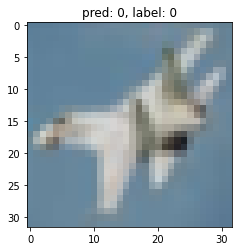

In [19]:
with torch.no_grad():
    idx = 10
    data = val_ds[idx]
    img, label = data
    img_input = img.unsqueeze(0).to(ptu.DEVICE)
    pred, _ = model_reload(img_input)
    pred = pred.detach().cpu().argmax(dim=1).item()

vis_images(img, titles=[f"pred: {pred}, label: {label}"])